By Hanna Yurchyk (260948680), Alexis Viau-Cardinal (260988139).

# Dependencies

In [ ]:
%%capture
!pip install pandas numpy tqdm matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as klayers
from keras.regularizers import L2
import seaborn as sns
import matplotlib.pylab as plt

In [ ]:
print(tf.__version__)
tf.keras.backend.set_floatx('float64')

2.12.0


# Data Pre-processing

In [ ]:
%%capture
!rm -rf archive.zip stocks/ etfs/ symbols_valid_meta.csv
!wget https://github.com/hannayurchyk/579-final-project-data/releases/download/release/archive.zip
!unzip archive.zip

In [ ]:
metadata = pd.read_csv('symbols_valid_meta.csv')

In [ ]:
stock_metadata = metadata[metadata['ETF']=='N']
stock_metadata.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
5,Y,AAL,"American Airlines Group, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,AAL,N
6,Y,AAMC,Altisource Asset Management Corp Com,A,,N,100.0,N,NaN,AAMC,AAMC,N


In [ ]:
stocks_data = {}
start_date = pd.Timestamp(2018, 4, 1) # 1 April 2018

AVG_TRADE_VOLUME = 500_000

end_date = pd.Timestamp(2020, 4, 1) # 1 April 2020

for _, stock in stock_metadata['NASDAQ Symbol'].items():
  stock_data = pd.read_csv(f'stocks/{stock}.csv')
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])
  if stock_data['Date'].min() > start_date:
    continue
  if stock_data['Date'].max() < end_date:
    continue
  if stock_data['Volume'].mean() < AVG_TRADE_VOLUME:
    continue

  mask = (stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)
  stock_data_masked = stock_data.loc[mask]
  stocks_data[stock] = stock_data_masked[['Date', 'High', 'Low', 'Close']].reset_index(drop=True)

## Input Data Formatting

In [ ]:
NUM_STOCKS = 10 # Number of stocks for portfolio management
NUM_STOCKS_ALL = NUM_STOCKS*11 # 1 Training set, 10 testing sets
TRADE_DAYS = 0 # Total number of trading days -> trading days in 6 years (5 days a week)
FEATURES = 3 # High, Low, Close prices

EPOCH_SUBSET_SIZE = 4 * 4 * 5 # Size of the input provided to compute a trajectory -> 4 months
# EPOCH_SUBSET_STEP = int(EPOCH_SUBSET_SIZE * 1/4) # CNN: Desired trajectory overlap ratio -> 3 month overlap
EPOCH_SUBSET_STEP = int(EPOCH_SUBSET_SIZE * 3/4) # RNN: Desired trajectory overlap ratio -> 1 month overlap

To fill NaNs, flat fake price-movements (0 decay rates) are used to fill the missing data points.

In [ ]:
# Choose stocks and fill missing values
np.random.seed(666)
stock_choices = np.sort(np.random.choice(list(stocks_data.keys()), NUM_STOCKS_ALL, replace=False))
stock_choices_dict = {}

# Retreive all dates
largest = 0
dates = pd.Series(dtype='datetime64[ns]', name='Date')
for stock in stock_choices:
  dates = pd.concat([dates, stocks_data[stock]['Date']]).drop_duplicates()
dates.reset_index(drop=True, inplace=True)
dates.sort_values(inplace=True)
TRADE_DAYS = dates.shape[0] # Overwrite trade days

# Fill all blank dates
for stock in stock_choices:
  stock_choices_dict[stock] = pd.merge(dates, stocks_data[stock], on='Date', how='left').fillna(method='backfill')

In [ ]:
train_names = list(stock_choices_dict.keys())[:NUM_STOCKS]

In [ ]:
train_dfs = [stock_choices_dict[name]['Close'] for name in train_names]
train_df = pd.concat(train_dfs, axis=1, keys=train_names)
train_df['Date'] = dates
train_df.set_index('Date')

,ACB,AGN,AMRN,APTV,ARCC,BIDU,BLMN,BSMX,BX,BYD
Date,,,,,,,,,,
2018-04-02,6.850,162.270004,2.92,81.580002,15.94,220.059998,24.070000,7.10,31.469999,30.760000
2018-04-03,6.270,164.740005,2.93,82.580002,15.91,220.020004,24.480000,7.30,31.120001,31.400000
2018-04-04,6.000,166.470001,3.16,84.220001,16.00,224.300003,24.709999,7.39,31.299999,32.029999
2018-04-05,6.647,165.130005,3.03,85.900002,16.02,225.570007,24.799999,7.47,31.299999,33.119999
2018-04-06,6.323,161.520004,3.01,83.820000,15.98,219.820007,24.690001,7.42,31.010000,32.000000
...,...,...,...,...,...,...,...,...,...,...
2020-03-26,0.905,175.539993,13.70,55.279999,11.92,101.820000,7.840000,3.40,48.000000,16.920000
2020-03-27,1.030,173.000000,13.24,51.279999,11.29,97.629997,6.660000,3.19,46.090000,15.300000
2020-03-30,0.888,176.309998,13.58,49.919998,10.64,98.949997,6.780000,3.18,47.279999,15.110000


In [ ]:
train_dfs2 = [stock_choices_dict[name] for name in train_names]
train_df2 = pd.concat(train_dfs2, axis=0, keys=train_names)
train_df2 = train_df2.reset_index()
train_df2.rename(columns={'level_0': 'Stocks'}, inplace=True)

[Text(0.5, 1.0, 'Train Stocks Closing Prices')]

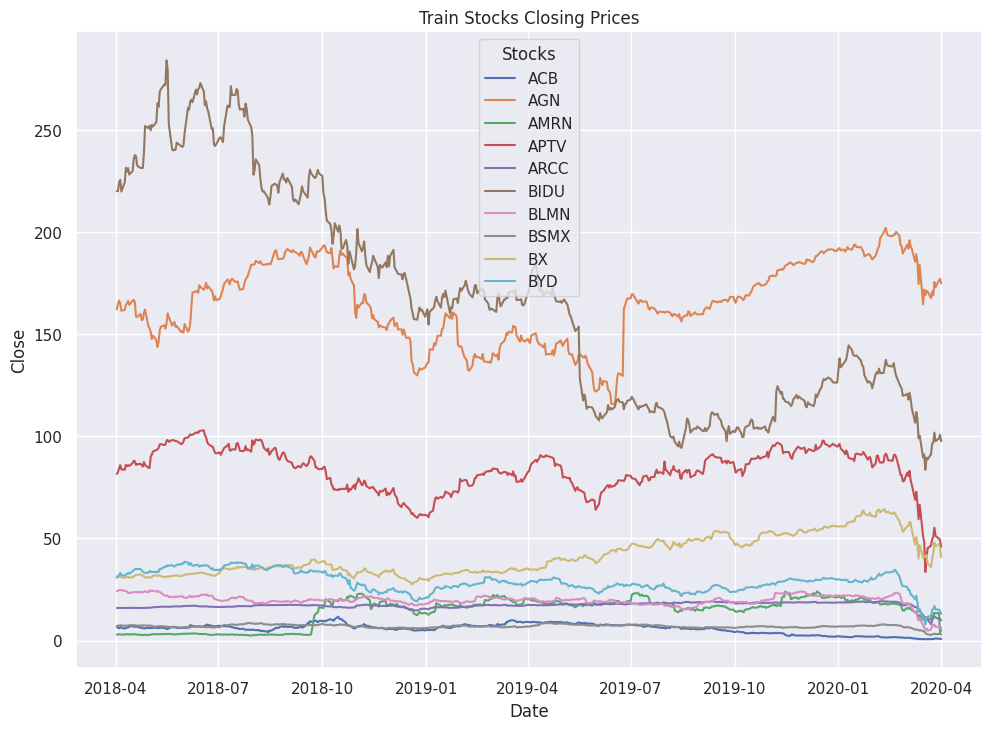

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(train_df2, x = 'Date', y = 'Close', hue = 'Stocks', dashes = False).set(title='Train Stocks Closing Prices')

In [ ]:
# Divide input for trajectories
HIGH = 'High'
LOW = 'Low'
CLOSE = 'Close'
FEATURES_NAMES = [HIGH, LOW, CLOSE] # IMPORTANT to keep this ordering b/c of tensor input dependency

data = np.zeros((NUM_STOCKS_ALL, TRADE_DAYS, FEATURES))
for index, stock in enumerate(stock_choices):
  data[index] = stock_choices_dict[stock][FEATURES_NAMES].to_numpy()

In [ ]:
data.shape # Dataset: 110 stocks, 1512 trading days, 3 features

(110, 505, 3)

In [ ]:
tr_shape = (NUM_STOCKS, EPOCH_SUBSET_SIZE, FEATURES)
epoch_subsets = np.lib.stride_tricks.sliding_window_view(data[:NUM_STOCKS, :, :], tr_shape)
epoch_subsets = np.squeeze(epoch_subsets, axis=(0,2))[::EPOCH_SUBSET_STEP, :, :, :]
epoch_subsets.shape # Dataset: 24 trajectories, 10 stocks, 80 days per trajectory, 3 features
epoch_subsets.shape

(8, 10, 80, 3)

In [ ]:
train_epoch_subsets = epoch_subsets[:, :NUM_STOCKS, :, :]
test_epoch_subsets = data[NUM_STOCKS:, :, :]

In [ ]:
train_epoch_subsets.shape # 10 stocks, 80 days, 3 features

(8, 10, 80, 3)

In [ ]:
test_epoch_subsets.shape # 10 stocks * 10 tests, 1512 days of testing, 3 features

(100, 505, 3)

In [ ]:
def baseline(testset):
  closing_prices = testset[:, :, 2]
  return np.mean(np.divide(closing_prices, closing_prices[:, 0, None]).T, axis=1)

# Helper functions

In this section, we will introduce all the necessary elements to construct our agent. More specifically, the following sections include all the helper functions as well as their justifications regarding the data encodings. More specifically, we will focus on the encoding of a *price relative vector*, the encoding of the *tensor* that will be input into the neural network, and the encoding of the *transaction costs*. Once these parts are complete, we will proceed to the logical encoding of the agent.

## Encodings



### Price Relative Vector

The portfolio consists of $m$ assets. The closing prices of all assets comprise the price vector $\vec{v}^{\,}_{t}$ for a period $t$. Similarly, let us denote $\vec{v}^{\,(hi)}_{t}$ and $\vec{v}^{\,(lo)}_{t}$ the highest and lowest prices of a period respectively. The *first* asset in the portfolio refers to the amount of *cash* available. Thus, the first elements of $v_{0,t} = v^{(hi)}_{0,t} = v^{(lo)}_{0,t} = 1, ∀t$

For continuous markets, the prices $\vec{v}^{\,}_{t}$ are the opening prices for period $t+1$ and closing prices for period $t$. Hence, for all assets $m$, the closing price relative vector at a period $t$ is denoted as follows:
$$
\vec{y}^{\,}_{t} := \vec{v}^{\,}_{t} ⊘ \vec{v}^{\,}_{t-1} = (1, \frac{v_{1,t}}{v_{1,t-1}}, \frac{v_{2,t}}{v_{2,t-1}}, ... ,\frac{v_{m,t}}{v_{1,m-1}})^{T}
$$

Because we are training on a number of periods, which we denote as `WINDOW_SIZE` in the code and $n$ for the purpose of illustration, the matrix form for several periods is visualized below:
$$Y=[\vec{y}^{\,}_{t-n+1}, \vec{y}^{\,}_{t-n+2}, ..., \vec{y}^{\,}_{t}] =
\begin{bmatrix}
1_{0,t-n+1} & 1_{0,t-n+2} & ... & 1_{0,t}\\
v_{1,t-n+1}/v_{1,t-n} & v_{1,t-n+1}/v_{1,t-n+2} & ... & v_{1,t}/v_{1,t-1} \\
\vdots & \vdots & \ddots & \vdots \\
v_{m,t-n+1}/v_{m,t-n} & v_{m,t-n+1}/v_{m,t-n+2} & ... & v_{m,t}/v_{m,t-1} \\
\end{bmatrix}
$$

In such case, the matrix $V$ is simply the matrix of prices for a number of periods $n$.

Finally, it is important to note that the same logic applies to $Y^{(hi)}$ and $Y^{(lo)}$.

In [ ]:
def compute_price_relative_vector(V, y_last): # Takes as input the price vector of outer size m without the cash
  v_cash = np.ones(V.shape[0])
  Y = np.divide(V[:, 1:], V[:, :-1])
  # Y = np.insert(Y, 0, np.divide(V[:,0], y_last), axis=1)
  Y = np.insert(Y, 0, v_cash, axis=0)
  return Y # Output yector is m + 1

### Price Tensor

Historic price data is fed into the neural network as a normalized tensor $X_t$, where all closing, high and low prices are normalized by the last closing price. The following equation demonstrate the composition of the normalized price matrices $V^{i}_{t}$.

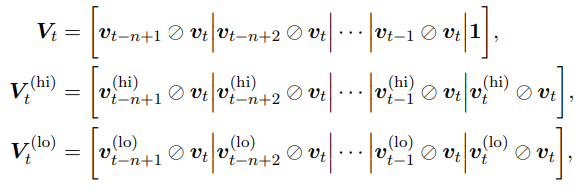

Where $1 = (1,1,...,1)^{T}$ is the unit vector and $⊘$ is the element-wise division operator.

Finally, the full tensor is illustrated as follows:

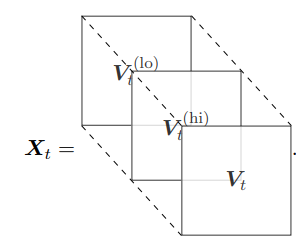



In [ ]:
def gen_input_tensor(window_price_data): # Assumes last index contains entries in order: [HIGH, LOW, CLOSE]
  last_closing_prices = window_price_data[:, -1, -1] # Change index here if the assumption fails
  norm_price_data = np.zeros(window_price_data.shape)
  for i, closing_price in enumerate(last_closing_prices):
    norm_price_data[i] = np.divide(window_price_data[i], closing_price)
  return tf.convert_to_tensor(norm_price_data, dtype = tf.dtypes.float64)

### Computing Transaction Costs

In real-world scenario, buying and selling assets is not free. We will account for this by introducing a constant commision rate that will shrink the portfolio value by a factor of $μ ∈ (0, 1]$ that will be called the *transaction remainder factor*. The following figure shows the effect of $μ$.
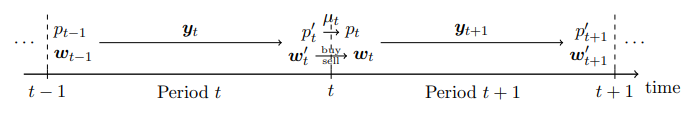

The market movement during period $t$, represented by the price-relative vector $\vec{y}^{\,}_{t}$, drives the portfolio value and portfolio weights from $\vec{p}^{\,}_{t-1}$ and $\vec{w}^{\,}_{t-1}$ to $\vec{p'}^{\,}_{t}$ and $\vec{w'}^{\,}_{t}$. The asset selling and asset purchasing action at time $t$ redistributes the fund into $\vec{w}^{\,}_{t}$. This transaction has a cost and will shrink the portfolio value $p'_{t}$ by $μ_{t}$. In other words:
$$
p_{t} = μ_{t}p'_{t}
$$
Before introducing the formula to compute $μ$ at each period, it is important to clarify that the PVM memory only stores $\vec{w}^{\,}_{t}$ and not $\vec{w'}^{\,}_{t}$. The former is only used for the computation of $μ$ and is calculated as follows:
$$
\vec{w'}^{\,}_{t} = \frac{\vec{y}^{\,}_{t}\odot\vec{w}^{\,}_{t-1}}{\vec{y}^{\,}_{t}\cdot\vec{w}^{\,}_{t-1}}
$$



The transaction remainder factor is approximated at each time step and will allow us to compute the rate of return $R$ more accurately. The transaction remainder factor is computed as follows:
$$
μ_{t} = \frac{1}{1-c_{p}w'_{t,0}}[1-c_{p}w'_{t,0}-(c_s+c_p-c_sc_p)∑^{m}_{i=1}ReLu(w'_{t,i}-μ_{t}w_{t,i})]
$$
Where $c_p$ is the transaction rate for purchasing, $c_s$ is the transaction rate for selling, and $c_p = c_s = 0.25\%$. At each computation of the porfolio weights, $μ$ is recursively approximated using 10 iterations.

Finally, the initial value $μ_{0}$ is defined as follows:
$$
μ_{0} = c∑\limits_{i=1}^{m}|w'_{0,i}-w_{0,i}|
$$
Where $\vec{w}^{\,}_{0}$ is associated to the weight given to the cash bias.


In [ ]:
COMMISSION_RATE = c = 0.0025

def ReLu(x):
  return tf.nn.relu(x)

def compute_w_prime(w_prev, y):
  mul = tf.multiply(y, w_prev)
  dot = tf.reduce_sum(mul)
  return tf.math.divide(mul, dot)

def compute_p_prime(p_prev, y, w_prev):
  mul = tf.multiply(y, w_prev)
  dot = tf.reduce_sum(mul)
  return p_prev * dot

def compute_commission_rate(w, w_prime, c, iter_c = 10):
  w = tf.squeeze(w, axis = 0)
  w_prime = tf.squeeze(w_prime, axis = 0)
  def mu_iter(mu):
    return 1 / (1 - c * w[0]) * (1 - c * w_prime[0] - (2*c - c**2) * tf.reduce_sum(ReLu(w_prime - mu * w)))

  default_mu = c*tf.reduce_sum(tf.abs(w_prime - w))

  for i in range(iter_c):
    default_mu = mu_iter(default_mu)

  return default_mu

## Reinforcement Learning Setting

The portfolio management problem is solved a reinforcement learning (RL) solution framework using a deterministic policy gradient algorithm. The state is $s_t = (X_t, w_{t-1})$, which represents the external and internal state. The agent analyzes the state and outputs an action. The action is based on a fully-exploitative policy $a_{t} = π(X_{t}, w_{t-1})  = w_{t}$. The reward function computes the average logaithmic cumulated return R given as follows:

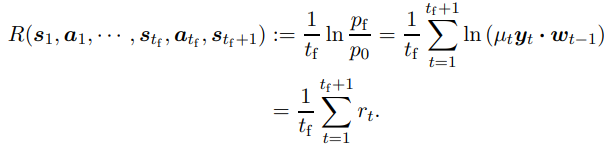

The agent seeks to maximize this reward function using a gradient ascent algorithm as follows:

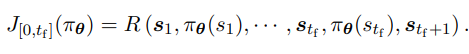

The initial weights are randomized and can be updated using the following full-batch rule:

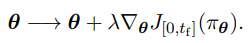

However, we will use the mini-batch update rule suggested in the paper:

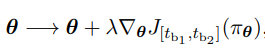

In [ ]:
def compute_rho(portfolio_value):
  one = tf.ones(shape = (1,), dtype=tf.float64)
  concat = tf.concat([portfolio_value], axis = 0)
  sub = tf.math.divide(concat[1:], concat[:-1])
  return tf.concat([one, sub], axis = 0)

In [ ]:
def compute_r(rho_value):
  return tf.math.log(rho_value)

In [ ]:
def mean_log_cummulated_return(r_value):
  return tf.reduce_sum(r_value)

## Mini-Batches

The mini-batches are selected from the trajectoy using the geometric probability distribution with $β=0.5$. This is done because data sets are time series and the most recent samples is more valuable than data from the past samples. Hence, batches with a significant overlap are valid training samples.

In [ ]:
def compute_mini_batches(batch_size, batches_count = 50, beta = 0.02):
  return np.clip(np.random.geometric(beta, size = (batches_count, )), 0, batch_size)

# Network architectures

In [ ]:
TYPE = 'type'

class NeuralNetwork:
  def __init__(self, stock_count, time_period, features, recall_count):
    '''
    :param stock_count: number of input stocks
    :param time_period: size of the input tensor
    :param features: feature number (high, low and close price changes)
    :param recall_count: size of the input PVM
    '''
    self.features = features
    self.stock_count = stock_count
    self.time_period = time_period
    self.recall_count = recall_count

    self.initializer = tf.keras.initializers.RandomNormal(mean = 1, stddev = 1e-3, seed=666)

    self.input_tensor = keras.Input(shape=(stock_count, time_period, features), dtype=tf.dtypes.float64)
    self.previous_w = keras.Input(shape=(stock_count, 1, recall_count), dtype=tf.dtypes.float64)

    self.output = self.network_end(self.build_network())

    self.model = keras.models.Model([self.input_tensor, self.previous_w], self.output)
    self.train_model = keras.models.Model([self.input_tensor, self.previous_w], self.model.layers[-2].output)

  def build_network(self):
    pass

  def network_end(self, network):
    concat =  klayers.Concatenate(axis = 3)([network, self.previous_w])

    conv = klayers.Conv2D(filters = 1,
                          kernel_size = (1, 1),
                          activation = 'relu',
                          input_shape = concat.shape[1:],
                          kernel_initializer = self.initializer)(concat)

    cash_bias = tf.ones_like(conv)[:, 0:1, :, :] # NONE, 1, 1, 1
    concat2 = klayers.Concatenate(axis = 1)([cash_bias, conv])

    squeeze = tf.squeeze(concat2, axis = (2, 3))

    return klayers.Activation('softmax')(squeeze)


### CNN

In [ ]:
class CNN(NeuralNetwork):
  def build_network(self):
    conv = klayers.Conv2D(filters = 2,
                          kernel_size = (1,3),
                          strides = (1, 1),
                          kernel_regularizer = L2(0.01),
                          activation = 'relu',
                          input_shape = self.input_tensor.shape[1:],
                          kernel_initializer = self.initializer)(self.input_tensor)

    conv2 = klayers.Conv2D(filters = 1,
                           kernel_size = (1, WINDOW_SIZE-2),
                           strides = (1, 1),
                           kernel_regularizer = L2(0.01),
                           activation = 'relu',
                           input_shape = conv.shape[1:],
                           kernel_initializer = self.initializer)(conv)

    return conv2


### RNN


In [ ]:
class RNN(NeuralNetwork):
  def build_network(self):
    rnns = []

    rnn_layer = klayers.SimpleRNN(20, kernel_initializer = self.initializer)
    dense_layer = klayers.Dense(units=1)
    print(rnn_layer)

    for i in range(self.stock_count):
      tensor = self.input_tensor[:, i, :, :]
      rnn = rnn_layer(tensor)
      dense = dense_layer(rnn)
      rnns.append(dense)

    concat = klayers.Concatenate()(rnns)

    return tf.expand_dims(tf.expand_dims(concat, axis = 2), axis = 3)


# Agent Class

In [ ]:
DEFAULT_BASIS = tf.expand_dims(tf.constant(np.random.dirichlet(np.ones(NUM_STOCKS + 1)), dtype = tf.dtypes.float64), axis = 1)

In [ ]:
class PortfolioManager:
  def __init__(self, nn, epoch_subsets, minibatch_size, num_minibatches, window_size, recall_count, commission_rate, learning_rate):
    '''
    : param nn: NeuralNetwork agent used
    : param nn_gradient: Tensorflow.Function used to update the weights of nn
    : param epoch_subsets: list of sequence of prices
    '''
    self.nn = nn
    self.epoch_subsets = epoch_subsets
    self.minibatch_size = minibatch_size
    self.num_minibatches = num_minibatches
    self.window_size = window_size
    self.recall_count = recall_count
    self.commission_rate = commission_rate
    self.learning_rate = learning_rate

    # Instantiate an optimizer
    self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipvalue=1.0)


  def fit(self):
    pass


  def predict(self, test_dataset):
    pass

In [ ]:
def fit(self):
  returns = []
  with tf.GradientTape(persistent = True, watch_accessed_variables=True) as tape:

    for epoch in tqdm(self.epoch_subsets, desc = f'Epoch training progress'):
      pvm = [DEFAULT_BASIS] * self.recall_count # create padding for PVM
      portfolio_value = [tf.constant(1, dtype = tf.float64)] # 1 is the default portfolio value

      batch_returns = [] # batch precomputed returns, done for TensorFlow efficiency
      rate_of_return = [tf.constant(1)]
      log_rate_of_return = []

      batches_indices = compute_mini_batches(epoch.shape[1] - self.window_size, batches_count = self.num_minibatches)

      # Iterate over batches of dataset
      for period in tqdm(range(self.window_size, epoch.shape[1]), desc = f'Minibatch training progress'):

          # Compute reward
          X = gen_input_tensor(epoch[:, period-self.window_size:period, :])
          X = tf.expand_dims(X, axis = 0)

          y = epoch[:,-1,-1]/epoch[:,-2,-1]
          y = tf.concat([tf.ones(shape = (1, ), dtype = tf.float64), y], axis = 0)
          y = tf.expand_dims(y, axis = 1)

          input_pvm = tf.concat(pvm[-self.recall_count:], axis = 1)
          input_pvm = tf.expand_dims(input_pvm, axis = 0) # adjusting for input
          input_pvm = tf.expand_dims(input_pvm, axis = 2) # adjusting for input

          w = self.nn.model([X, input_pvm[:, 1:, :, :]])
          pvm.append(tf.transpose(w))

          w_prime = tf.transpose(compute_w_prime(pvm[-2], y))

          mu = compute_commission_rate(w, w_prime, self.commission_rate)

          p_prime = compute_p_prime(portfolio_value[-1], y, pvm[-2])

          p = mu * p_prime

          portfolio_value.append(p)

          rate_of_return.append(portfolio_value[-1] / portfolio_value[-2] - 1)
          log_rate_of_return.append(tf.keras.backend.log(portfolio_value[-1] / portfolio_value[-2]))

          if epoch.shape[1] - period  in batches_indices:
            batch_return = - tf.reduce_sum(log_rate_of_return[- self.minibatch_size : ])
            grad = self.optimizer.compute_gradients(batch_return, self.nn.model.trainable_weights, tape=tape)
            self.optimizer.apply_gradients(grad)

      returns.append(tf.add_n(portfolio_value[:-epoch.shape[0]])/epoch.shape[0])
      print('AVG RETURN PER EPOCH', returns[-1])

  return returns

PortfolioManager.fit = fit

In [ ]:
def predict(self, test_dataset):
  # with tf.GradientTape(persistent = True, watch_accessed_variables=True) as tape:
    pvm = [DEFAULT_BASIS] * self.recall_count # create padding for PVM
    portfolio_value = [tf.constant(1, dtype = tf.float64)] # 1 is the default portfolio value

    # batch_returns = [] # batch precomputed returns, done for TensorFlow efficiency
    rate_of_return = [tf.constant(1)]
    log_rate_of_return = []

    # Iterate over batches of dataset
    for period in tqdm(range(self.window_size, test_dataset.shape[1]), desc = f'Period Iteration'):

      # Compute reward
      X = gen_input_tensor(test_dataset[:, period-self.window_size:period, :])
      X = tf.expand_dims(X, axis = 0)

      y = test_dataset[:,-1,-1]/test_dataset[:,-2,-1]
      y = tf.concat([tf.ones(shape = (1, ), dtype = tf.float64), y], axis = 0)
      y = tf.expand_dims(y, axis = 1)

      input_pvm = tf.concat(pvm[-self.recall_count:], axis = 1)
      input_pvm = tf.expand_dims(input_pvm, axis = 0) # adjusting for input
      input_pvm = tf.expand_dims(input_pvm, axis = 2) # adjusting for input

      w = self.nn.model([X, input_pvm[:, 1:, :, :]])
      pvm.append(tf.transpose(w))

      w_prime = tf.transpose(compute_w_prime(pvm[-2], y))

      mu = compute_commission_rate(w, w_prime, self.commission_rate)

      p_prime = compute_p_prime(portfolio_value[-1], y, pvm[-2])

      p = mu * p_prime

      portfolio_value.append(p)
      rate_of_return.append(portfolio_value[-1] / portfolio_value[-2] - 1)
      log_rate_of_return.append(tf.keras.backend.log(portfolio_value[-1] / portfolio_value[-2]))

    return portfolio_value

PortfolioManager.predict = predict

# Training & Graphs

In [ ]:
# HYPER PARAMETERS
MINIBATCH_SIZE = 20
NUM_MINIBATCHES = 40
LEARNING_RATE = 1

WINDOW_SIZE = 50
RECALL_COUNT = 25

In [ ]:
# TRAIN_DATA_SIZE = WINDOW_SIZE + 484 # floor(test_epoch_subsets.shape[1]/22) * 22
train_data = data[:NUM_STOCKS, :, :]
train_data.shape

(10, 505, 3)

In [ ]:
cnn_model = CNN(NUM_STOCKS, WINDOW_SIZE, FEATURES, RECALL_COUNT)
cnn_manager = PortfolioManager(nn = cnn_model,
                               epoch_subsets = train_epoch_subsets,
                               minibatch_size = MINIBATCH_SIZE,
                               num_minibatches = NUM_MINIBATCHES,
                               window_size = WINDOW_SIZE,
                               recall_count = RECALL_COUNT,
                               commission_rate = COMMISSION_RATE,
                               learning_rate = LEARNING_RATE)

In [ ]:
train_return_cnn = cnn_manager.fit()

Epoch training progress:   0%|          | 0/22 [00:00<?, ?it/s]

Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.638434022940927, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.4510094161846903, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.0582011021417297, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.9987635284436727, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.063389671002869, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.958425064628593, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.234697979904417, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.001426990291015, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.4081504439053703, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.3086026317047734, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.0321131617813775, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.32232458073363, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.981223465566492, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.4683507699134015, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.217409712830988, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.384147443654247, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.891345306349803, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.9665451831182215, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.8033829911658814, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.2234404798024934, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(1.8097307092122246, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVF RETURN PER EPOCH tf.Tensor(2.1642079475795564, shape=(), dtype=float64)


In [ ]:
baseline_ = np.mean(np.split(baseline(train_data)[:484], 22), axis=1)

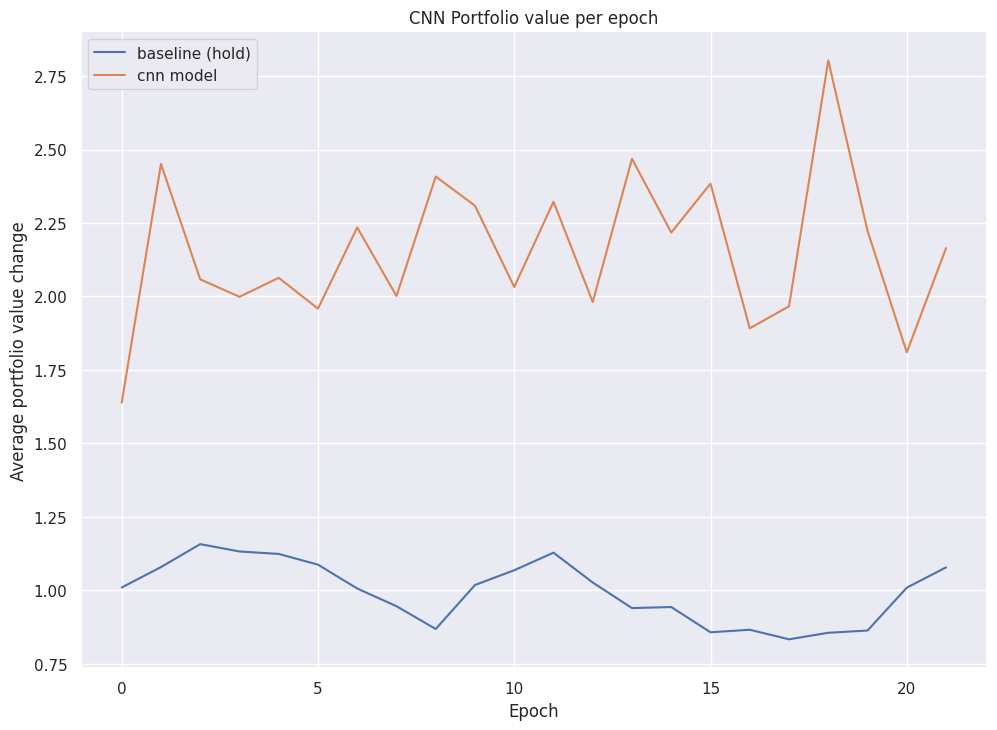

In [ ]:
plt.plot(baseline_, label = 'baseline (hold)')
plt.plot(train_return_cnn, label = 'cnn model')
plt.legend()
plt.title('CNN Portfolio value per epoch')
plt.xlabel('Epoch')
plt.ylabel('Average portfolio value change')
plt.show()

In [ ]:
rnn_model = RNN(NUM_STOCKS, WINDOW_SIZE, FEATURES, RECALL_COUNT)
rnn_manager = PortfolioManager(nn = rnn_model,
                               epoch_subsets = train_epoch_subsets,
                               minibatch_size = MINIBATCH_SIZE,
                               num_minibatches = NUM_MINIBATCHES,
                               window_size = WINDOW_SIZE,
                               recall_count = RECALL_COUNT,
                               commission_rate = COMMISSION_RATE,
                               learning_rate = LEARNING_RATE)

In [ ]:
train_return_rnn = rnn_manager.fit()

Epoch training progress:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(1.4997176672242425, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(2.271307264137563, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(2.3763078066329797, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(1.7957903756734812, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(1.9925654849417789, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(1.7904618092426237, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(1.907437845806447, shape=(), dtype=float64)


Minibatch training progress:   0%|          | 0/30 [00:00<?, ?it/s]

AVG RETURN PER EPOCH tf.Tensor(4.554589184854926, shape=(), dtype=float64)


In [ ]:
baseline_rnn = np.mean(np.split(baseline(train_data)[:504], 8), axis=1)

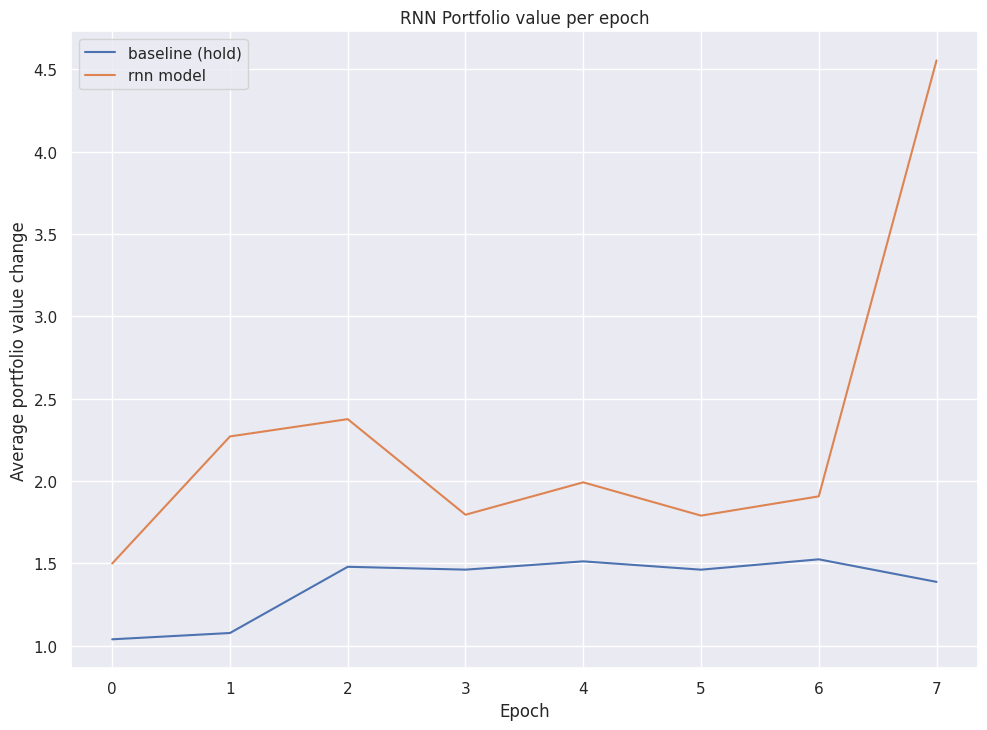

In [ ]:
plt.plot(baseline_rnn, label = 'baseline (hold)')
plt.plot(train_return_rnn, label = 'rnn model')
plt.legend()
plt.title('RNN Portfolio value per epoch')
plt.xlabel('Epoch')
plt.ylabel('Average portfolio value change')
plt.show()